# **Описание проекта: прогнозирование оттока клиентов для телекоммуникационной компании**

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

**Описание услуг**

Оператор предоставляет два основных типа услуг:
- Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
- Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:
- Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
- Выделенная линия технической поддержки (TechSupport);
- Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
- Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

**Описание данных**

Данные состоят из файлов, полученных из разных источников:
- contract_new.csv — информация о договоре;
- personal_new.csv — персональные данные клиента;
- internet_new.csv — информация об интернет-услугах;
- phone_new.csv — информация об услугах телефонии.

Во всех файлах столбец customerID содержит код клиента.  
Информация о договорах актуальна на 1 февраля 2020.

# План работы

1. Предобработка и исследовательский анализ данных:
- Загрузка библиотек и датасетов
- Оценка фронта работ на основе общей информации о датасетах
- Объединение датасетов
- Изменение типов данных
- Создание новых признаков (в том числе целевого)
- Заполнение пропущенных значений
- Проверка на дубликаты
- Построение матрицы корреляции
- Построение диаграмм
- Подведение итогов этапа анализа

2. Обучение моделей:
- Очистка датасета от лишних столбцов
- Разделение данных на features и target
- Разделение датасета на тренировочную и тестовую выборку в соотношении 3 к 1
- Масштабирование признаков
- Кодирование признаков
- Обучение моделей
- Выбор лучшей модели
- Проверка лучшей модели на тестовой выборке (добиться значения ROC-AUC >= 0.85)
- Анализ результатов
- Подведение итогов этапа обучения моделей

3. Составить отчет по итогам проделанной работы

## Предобработка и исследовательский анализ данных

In [ ]:
#Устанавливаем библиотеку phik и обновляем библиотеки до последней версии
!pip install phik
!pip install -U scikit-learn

In [ ]:
#Импортируем библиотеки
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import phik
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, confusion_matrix
from phik.report import plot_correlation_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [ ]:
#Задаем константу
RANDOM_STATE = 310723

### Предобработка данных

Поскольку у заказчика может не быть доступа к файлам из внутренней сети Практикума, предусмотрим доступ к ним по дополнительной ссылке.

In [ ]:
#Пишем функцию для сокращения кода и загружаем датасеты в переменные
def read_csv(path_one, path_two):
    try:
        return pd.read_csv(path_one)
    except:
        return pd.read_csv(path_two)

#Загружаем данные в переменные
df_contract = read_csv('/datasets/contract_new.csv', 'https://code.s3.yandex.net/datasets/contract_new.csv')
df_personal = read_csv('/datasets/personal_new.csv', 'https://code.s3.yandex.net/datasets/personal_new.csv')
df_internet = read_csv('/datasets/internet_new.csv', 'https://code.s3.yandex.net/datasets/internet_new.csv')
df_phone = read_csv('/datasets/phone_new.csv', 'https://code.s3.yandex.net/datasets/phone_new.csv')

#Посмотрим на файлы
display(df_contract.sample(5))
display(df_personal.sample(5))
display(df_internet.sample(5))
display(df_phone.sample(5))

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
58,3957-SQXML,2017-04-01,No,Two year,No,Credit card (automatic),24.95,890.72
7037,2569-WGERO,2014-02-01,No,Two year,Yes,Bank transfer (automatic),21.15,1553.26
6228,8597-CTXVJ,2014-04-01,No,One year,No,Bank transfer (automatic),64.95,5001.15
5062,2911-UREFD,2016-09-01,No,Month-to-month,No,Electronic check,55.90,2429.41
1750,4137-JOPHL,2015-12-01,No,Two year,Yes,Bank transfer (automatic),89.70,4888.65


,customerID,gender,SeniorCitizen,Partner,Dependents
2785,4016-BJKTZ,Female,0,No,No
499,7783-YKGDV,Female,0,No,No
4266,5445-PZWGX,Male,0,No,No
2726,9392-XBGTD,Male,0,No,Yes
2414,9621-OUPYD,Female,0,Yes,No


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
3639,7571-YXDAD,Fiber optic,No,No,No,No,No,No
3735,5216-WASFJ,Fiber optic,No,No,No,No,No,Yes
3236,6834-NXDCA,DSL,No,No,No,No,No,No
81,8637-XJIVR,Fiber optic,Yes,No,No,No,No,No
1769,1399-UBQIU,DSL,No,No,Yes,No,Yes,Yes


,customerID,MultipleLines
1041,3522-CDKHF,No
444,7783-YKGDV,Yes
3961,6741-QRLUP,Yes
5224,5937-EORGB,Yes
969,5536-RTPWK,Yes


In [ ]:
#Изучим общую информацию о датафреймах через info()
df_contract.info()
print('')
df_personal.info()
print('')
df_internet.info()
print('')
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   

In [ ]:
#Изучим общую информацию о датафреймах через describe()
display(df_contract.describe())
display(df_personal.describe())
display(df_internet.describe())
display(df_phone.describe())

,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,2675-DHUTR,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,2675-DHUTR,No
freq,1,3390


Первое, что бросается в глаза — несмотря на отсутствие пропусков в каждом отдельном датафрейме, общее количество строк в разных файлах не совпадает. Строки совпадают только в первых двух датафреймах, соответственно, объединять датафреймы будем по одному из них (по первому).  
Также есть несоответствие типов данных:
- в **df_contract** необходимо будет поработать с изменением типов данных в столбцах с датами; также надо будет что-то придумать с информацией об остутствии в столбце `EndDate` даты и наличием заглушки *No*
- в **df_contract** столбец `TotalCharges` явно содержит значения типа *float64*, надо посмотреть, почему тип данных *object* и исправить это
- в каждом датафрейме есть столбцы с типом данных *object*, где содержатся данные в формате *Yes* и *No*; мы могли бы сразу заменить их на единицы и нули, но предоставим эту возможность нашему кодировщику, который справится с этой непосильной задачей сам
- переделаем значения столбца `SeniorCityzen` на *Yes* и *No* — исключительно для удобства восприятия, раз уж у нас все столбцы с бинарными признаками представлены в этом формате
- дополнительно переназовем столбцы для соответствия змеиному_регистру


Начнем с объединения данных в единый датафрейм, с которым будет удобно работать.

In [ ]:
#Объединяем данные в единый датафрейм
df = pd.merge(df_contract, df_personal, on='customerID', how='left')
df = pd.merge(df, df_internet, on='customerID', how='left')
df = pd.merge(df, df_phone, on='customerID', how='left')

#Проверяем
display(df.sample(10))
df.info()
display(df.describe())

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
6536,3439-GVUSX,2020-01-01,No,Month-to-month,No,Mailed check,24.40,24.4,Male,0,No,No,DSL,No,No,No,No,No,No,NaN
798,3807-XHCJH,2020-01-01,No,Month-to-month,No,Electronic check,20.00,20.8,Female,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
1276,7005-CYUIL,2014-03-01,No,Two year,Yes,Electronic check,99.40,7057.4,Female,1,Yes,No,Fiber optic,Yes,Yes,Yes,Yes,Yes,No,No
6386,6656-GULJQ,2014-02-01,No,Two year,Yes,Credit card (automatic),83.55,6256.22,Male,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes
4685,0345-XMMUG,2016-04-01,No,Two year,Yes,Credit card (automatic),108.90,5209.78,Female,0,Yes,No,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,Yes
4771,1678-FYZOW,2019-07-01,2019-10-01,Month-to-month,Yes,Electronic check,79.40,250.11,Female,0,No,No,Fiber optic,No,No,No,No,Yes,No,No
2925,2931-XIQBR,2015-12-01,No,One year,No,Mailed check,103.05,5152.5,Female,0,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,No
615,9396-ZSFLL,2018-11-01,No,Month-to-month,No,Mailed check,48.85,776.72,Female,0,No,No,DSL,No,No,No,No,No,No,Yes
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
2224,2528-HFYZX,2018-07-01,2019-11-01,Month-to-month,Yes,Electronic check,76.45,1223.2,Male,1,Yes,No,Fiber optic,No,Yes,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


,MonthlyCharges,SeniorCitizen
count,7043.000000,7043.000000
mean,64.761692,0.162147
std,30.090047,0.368612
min,18.250000,0.000000
25%,35.500000,0.000000
50%,70.350000,0.000000
75%,89.850000,0.000000
max,118.750000,1.000000


In [ ]:
#Приведем названия столбцов к змеиному_регистру
columns_to_snake = {
    'customerID':'customer_id',
    'BeginDate':'begin_date',
    'EndDate':'end_date',
    'Type':'contract_type',
    'PaperlessBilling':'paperless_billing',
    'PaymentMethod':'payment_method',
    'MonthlyCharges':'monthly_charges',
    'TotalCharges':'total_charges',
    'gender':'gender',
    'SeniorCitizen':'senior_citizen',
    'Partner':'partner',
    'Dependents':'dependents',
    'InternetService':'internet_service',
    'OnlineSecurity':'online_security',
    'OnlineBackup':'online_backup',
    'DeviceProtection':'device_protection',
    'TechSupport':'tech_support',
    'StreamingTV':'streaming_tv',
    'StreamingMovies':'streaming_movies',
    'MultipleLines':'multiple_lines'
}

df = df.rename(columns=columns_to_snake)

#Проверяем
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   contract_type      7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
 8   gender             7043 non-null   object 
 9   senior_citizen     7043 non-null   int64  
 10  partner            7043 non-null   object 
 11  dependents         7043 non-null   object 
 12  internet_service   5517 non-null   object 
 13  online_security    5517 non-null   object 
 14  online_backup      5517 non-null   object 
 15  device_protection  5517 non-null   object 
 16  tech_support       5517 

Теперь названия столбцов выглядят прилично. Дополнительно мы изменили название столбца `Type` на `contract_type`, чтобы было понятнее, какие данные содержатся в столбце.

Займемся типами данных.

In [ ]:
#Поменяем тип данных столбца на правильный
df['total_charges'] = pd.to_numeric(df['total_charges'], errors ='coerce')

#Проверяем
print(df['total_charges'].dtype)
df.info()

float64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   contract_type      7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7032 non-null   float64
 8   gender             7043 non-null   object 
 9   senior_citizen     7043 non-null   int64  
 10  partner            7043 non-null   object 
 11  dependents         7043 non-null   object 
 12  internet_service   5517 non-null   object 
 13  online_security    5517 non-null   object 
 14  online_backup      5517 non-null   object 
 15  device_protection  5517 non-null   object 
 16  tech_support    

После смены типа данных у нас появились пропуски, посмотрим на них.

In [ ]:
#Проверяем пропуски
df[df['total_charges'].isna()]

,customer_id,begin_date,end_date,contract_type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,Female,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,NaN
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,NaN,Male,0,No,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,NaN,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,NaN,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,NaN,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,NaN
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,NaN,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,NaN,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,NaN,Female,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,NaN,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,NaN,Female,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Yes


Все ясно, причина в том, что платежи от клиентов просто не успели отобразиться в системе, поскольку контракты были заключены в день выгрузки. Решим эту проблему, заполнив пустые значения информацией из столбца `monthly_charges`

In [ ]:
#Заполняем пустые значения
df['total_charges'] = df['total_charges'].fillna(df['monthly_charges'])
#Проверяем
df['total_charges'].isna().sum()

0

Выделим целевой признак.

In [ ]:
#Создаем целевой признак с информацией об уходе клиента (1 - ушел, 0 - остался)
df['client_left'] = [1 if i != 'No' else 0 for i in df['end_date']]

#Проверяем
df['client_left'].value_counts()

0    5942
1    1101
Name: client_left, dtype: int64

Получилось.
Теперь займемся столбцами с датами — `begin_date` и `end_date`

In [ ]:
#Сперва проверим значения столбцов
display(df['begin_date'].value_counts())
display(df['end_date'].value_counts())

2014-02-01    366
2019-09-01    237
2019-11-01    237
2019-10-01    237
2020-01-01    233
             ... 
2020-02-01     11
2014-01-01      7
2013-12-01      3
2013-10-01      3
2013-11-01      2
Name: begin_date, Length: 77, dtype: int64

No            5942
2020-01-01      39
2019-12-01      38
2018-11-01      35
2019-09-01      32
              ... 
2015-04-01       2
2014-12-01       2
2014-10-01       1
2014-06-01       1
2014-11-01       1
Name: end_date, Length: 67, dtype: int64

Итак, мы видим, что в столбце `begin_date` все значения могут быть преобразованы в даты, а вот в столбце `end_date` есть значения **No**.

В наш план входит создание двух синтетических столбцов, которые пригодятся нам для обучения моделей.
Первый столбец будет содержать информацию о том, ушел ли клиент, в бинарном формате **1** или **0** — именно этот столбец будет нашим таргетом.
Второй столбец будет содержать информацию о количестве дней от начала сотрудничества с клиенитом или от начала сотрудничества до его ухода (в случае, если он ушел). Поскольку информация актуальна на момент 1 февраля 2020 года, последней датой для действующих клиентов будем считать её. При использовании модели в на новых и более свежих данных мы можем изменить актуальную дату на текущую.

Следуя этой логике, нам нужно будет заменить значения **No** столбца `end_date` на дату **2020-02-01**, после чего перевести данные в формат даты и сделать наши синтетические столбцы. После создания синтетических столбцов информация о датах нам больше не понадобится и впоследствие мы её удалим.

In [ ]:
#Заменяем No на 2020-02-01
df['end_date'] = df['end_date'].replace('No', '2020-02-01')

#Проверяем
display(df['end_date'].value_counts())

2020-02-01    5942
2020-01-01      39
2019-12-01      38
2018-11-01      35
2019-09-01      32
              ... 
2015-04-01       2
2014-12-01       2
2014-11-01       1
2014-06-01       1
2014-10-01       1
Name: end_date, Length: 67, dtype: int64

In [ ]:
#Меняем тип данных на datetime
df['begin_date'] = pd.to_datetime(df['begin_date'])
df['end_date'] = pd.to_datetime(df['end_date'])

#Проверяем
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   contract_type      7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   int64         
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  internet_service   5517 non-null   object        
 13  online_security    5517 non-null   object        
 14  online_b

Тип данных мы изменили, теперь создадим пару синтетических столбцов, один из которых в будущем станет целевым для обучения моделей, а второй будет одним из признаков.

In [ ]:
#Создаем столбец с информацией о количестве дней действия контракта
df['contract_lifetime'] = (df['end_date'] - df['begin_date']).dt.days

#Проверяем
df['contract_lifetime'].value_counts()

2191    265
153     249
92      243
31      236
123     236
       ... 
121       1
2253      1
424       1
1309      1
547       1
Name: contract_lifetime, Length: 251, dtype: int64

Мы намеренно не стали заменять значения количества дней действия контракта в столбце `contract_lifetime` на уникальные, вроде 99999, чтобы обозначить, что клиент остался, потому что в таком случае может возникнуть проблема со слишком сильной корреляцией нашего признака с целевым, а нам это не нужно, поскольку в таком случае модель может просто заигнорировать все остальные признаки и толку от такой модели не будет.

In [ ]:
#Меняем значения столбца senior_cityzen
df['senior_citizen'] = df['senior_citizen'].replace({1:'Yes', 0:'No'})
df['senior_citizen'].value_counts()

No     5901
Yes    1142
Name: senior_citizen, dtype: int64

Теперь заполним пустые значения в столбцах, относящихся к дополнительным услугам, которыми клиенты, вероятно, не пользовались

In [ ]:
#Заполняем пустые значения N/A
df = df.fillna('N/A')

#Проверяем
df.info()
display(df.sample(10))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   contract_type      7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   object        
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  internet_service   7043 non-null   object        
 13  online_security    7043 non-null   object        
 14  online_b

,customer_id,begin_date,end_date,contract_type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,client_left,contract_lifetime
1518,1925-GMVBW,2019-09-01,2020-02-01,Month-to-month,No,Credit card (automatic),20.55,102.75,Female,No,...,N/A,N/A,N/A,N/A,N/A,N/A,N/A,No,0,153
6872,5297-MDOIR,2014-11-01,2020-02-01,One year,Yes,Credit card (automatic),81.15,5470.32,Female,No,...,Fiber optic,Yes,No,Yes,No,No,No,No,0,1918
541,2782-LFZVW,2019-03-01,2020-02-01,Month-to-month,Yes,Mailed check,58.95,648.45,Female,No,...,DSL,No,No,No,No,No,Yes,Yes,0,337
5991,8063-RJYNF,2018-06-01,2020-02-01,Month-to-month,Yes,Electronic check,94.25,1941.55,Male,No,...,Fiber optic,Yes,No,No,No,Yes,Yes,No,0,610
2108,0842-IWYCP,2016-04-01,2020-02-01,Month-to-month,No,Bank transfer (automatic),44.95,2109.05,Female,No,...,DSL,No,No,No,No,No,No,No,0,1401
5290,0774-RMNUW,2014-03-01,2020-02-01,Two year,No,Bank transfer (automatic),59.70,4238.70,Female,No,...,DSL,Yes,Yes,No,Yes,Yes,Yes,N/A,0,2163
3942,6959-UWKHF,2019-12-01,2020-02-01,Month-to-month,Yes,Electronic check,42.90,85.80,Male,No,...,DSL,No,No,No,No,No,No,No,0,62
323,7102-JJVTX,2019-05-01,2020-02-01,One year,No,Mailed check,48.60,472.39,Female,No,...,DSL,Yes,No,No,No,No,No,No,0,276
561,7343-EOBEU,2019-11-01,2020-02-01,Month-to-month,Yes,Mailed check,23.60,70.80,Male,No,...,N/A,N/A,N/A,N/A,N/A,N/A,N/A,Yes,0,92
2621,8766-PAFNE,2014-03-01,2016-09-01,Two year,Yes,Credit card (automatic),79.10,2373.00,Male,No,...,DSL,No,Yes,Yes,Yes,Yes,Yes,No,1,915


Теперь, когда пропусков нет, стоит проверить данные на наличие дубликатов

In [ ]:
#Проверяем
df.duplicated().sum()

0

Дубликатов нет. Поле `customer_id` будет нам дальше только мешать, поэтому переместим его в индексы нашего датафрейма

In [ ]:
df = df.set_index('customer_id')

### Матрица корреляции

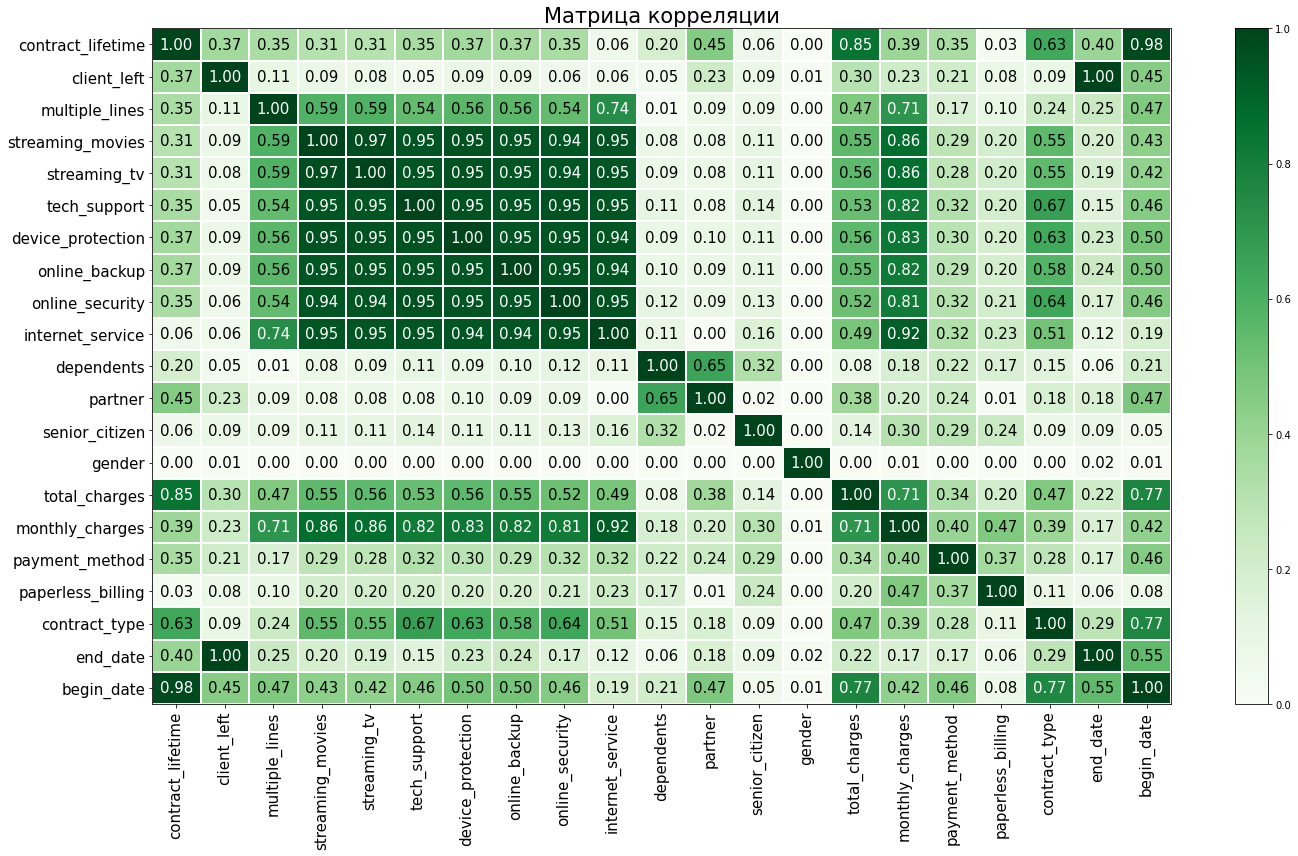

In [ ]:
#Строим тепловую карту корреляции
interval_cols = ['monthly_charges',
                 'total_charges',
                 'contract_lifetime']

phik_overview = df.phik_matrix(interval_cols=interval_cols)

plot_correlation_matrix(phik_overview.values, x_labels=phik_overview.columns, y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map='Greens', title=r'Матрица корреляции', fontsize_factor=1.5,
                        figsize=(20, 12))
plt.tight_layout()

Исходя из матрицы, можем сказать следующее:
- Сильнее всего корреляция с целевым признаком `client_left` наблюдается у столбцов с датами начала и окончания контракта, о чем ранее мы уже упоминали, от них придется избавиться
- Также можно увидеть, что столбец `total_charges` мультиколлинеарен к столбцу `contract_lifetime` со сроком действия контракта, что вполне логично, ведь чем дольше контракт, тем больше клиент заплатит в итоге — `total_charges` придется удалить
- Столбец `gender` здесь явно ни на что не виляет, от него также избавимся
- Если отсечь столбцы, указанные выше, наиболее сильное влияние на целевой признак оказывают столбцы `contract_lifetime` (срок действия контракта), `partner`(наличие супруга/супруги), `monthly_payment` (ежемесячный платеж) и `payment_method` (способ оплаты)

### Построение и анализ диаграмм признаков

Теперь построим диаграммы для категориальных и количественных признаков и заодно оценим баланс классов в целевом признаке

In [ ]:
#Создадим списки со количественными и категориальными столбцами
num_cols = []
cat_cols = []

for i in df.columns:
    if df[i].dtype == 'object':
        cat_cols.append(i)
    elif df[i].dtype in ['float64', 'int64']:
        num_cols.append(i)

if 'client_left' in num_cols:
    num_cols.remove('client_left')

display(num_cols)
display(cat_cols)

['monthly_charges', 'total_charges', 'contract_lifetime']

['contract_type',
 'paperless_billing',
 'payment_method',
 'gender',
 'senior_citizen',
 'partner',
 'dependents',
 'internet_service',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'multiple_lines']

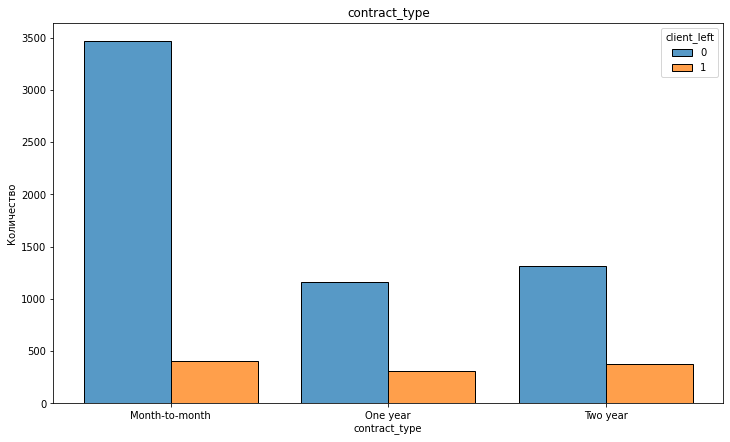

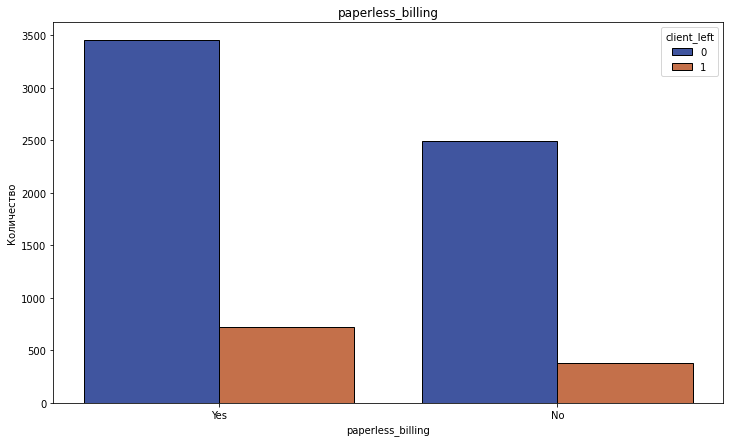

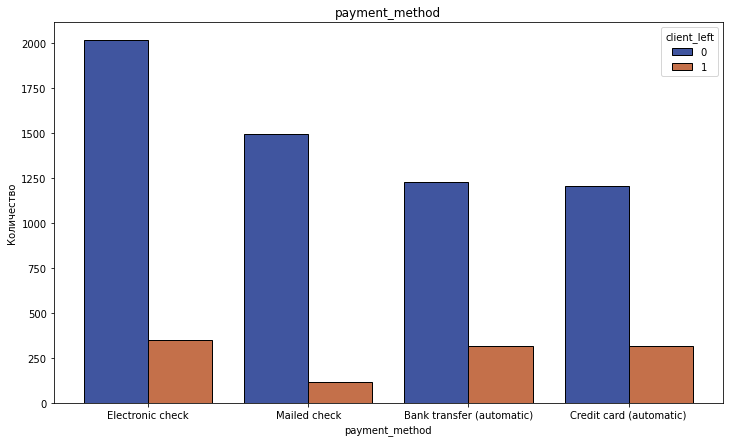

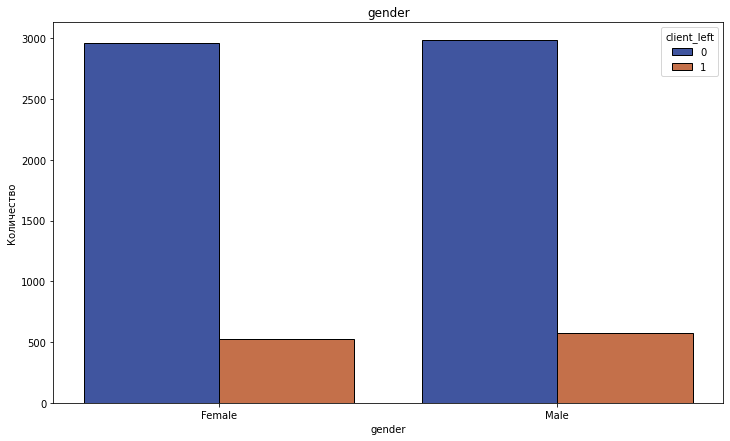

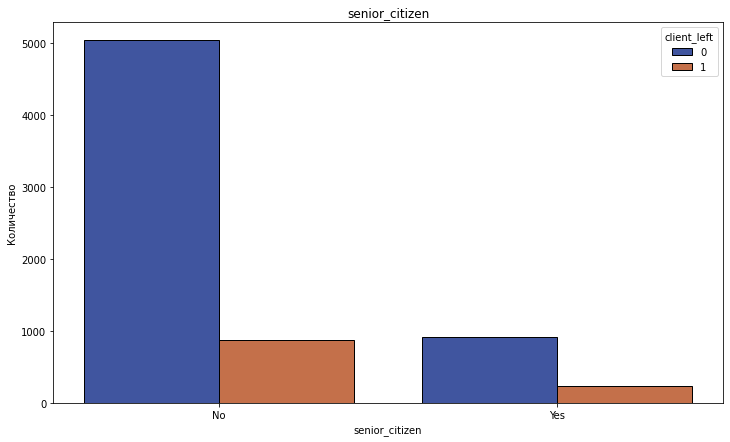

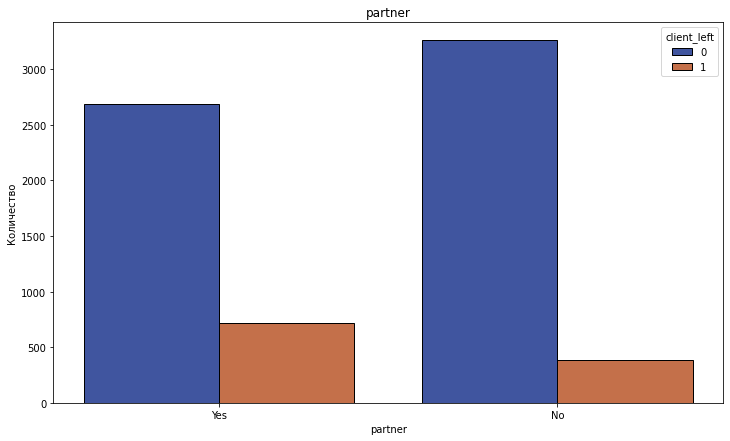

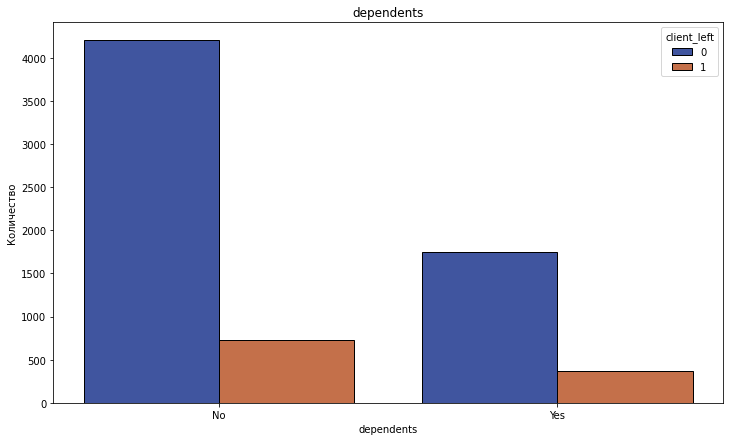

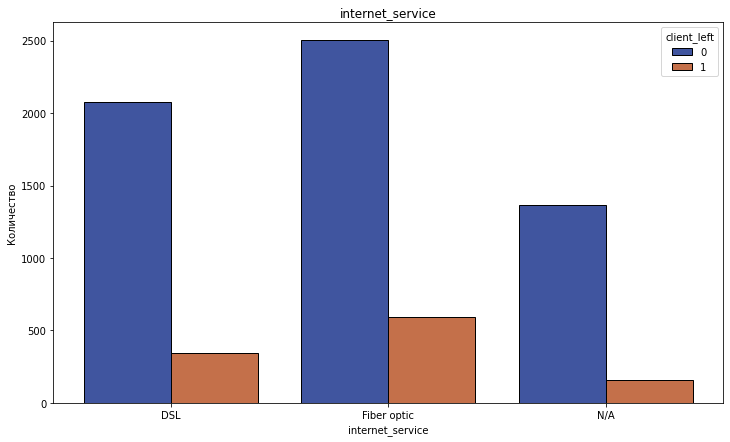

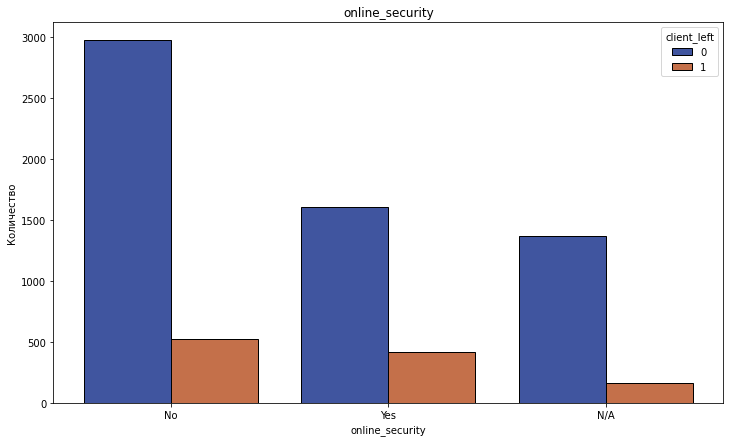

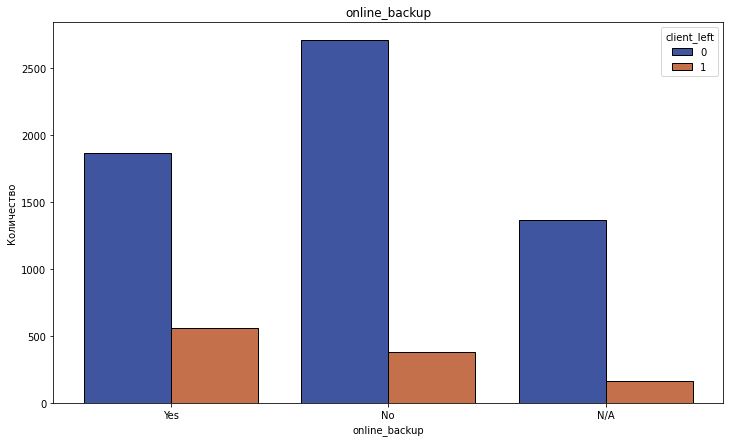

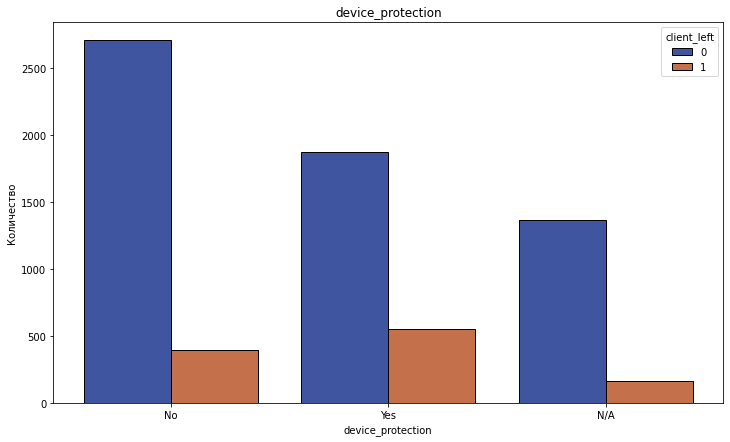

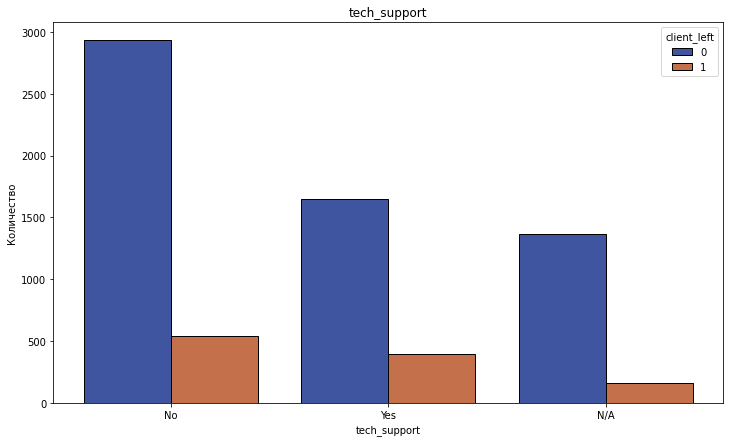

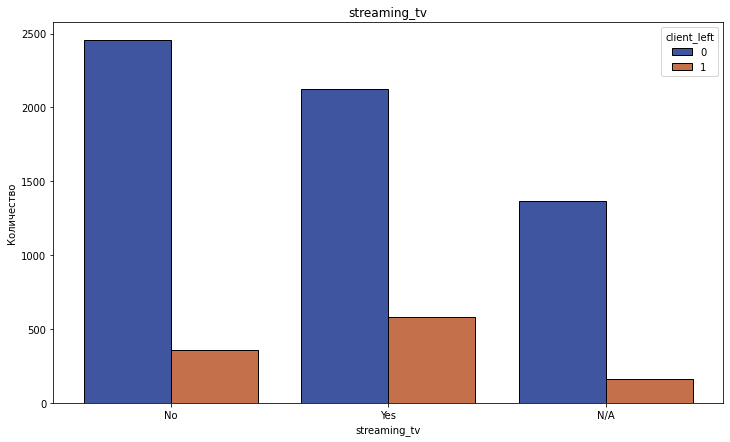

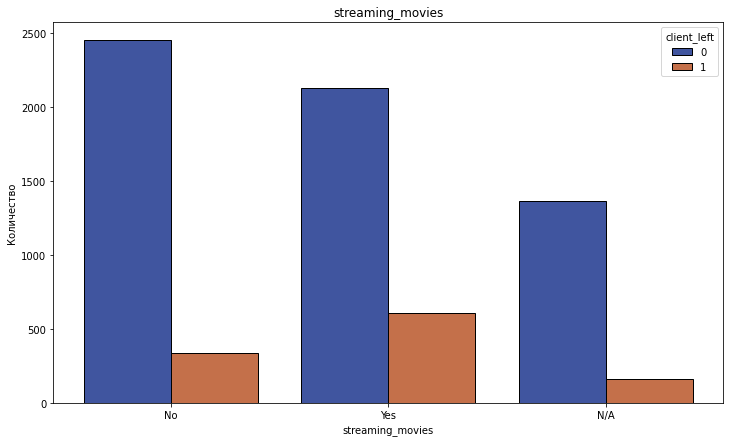

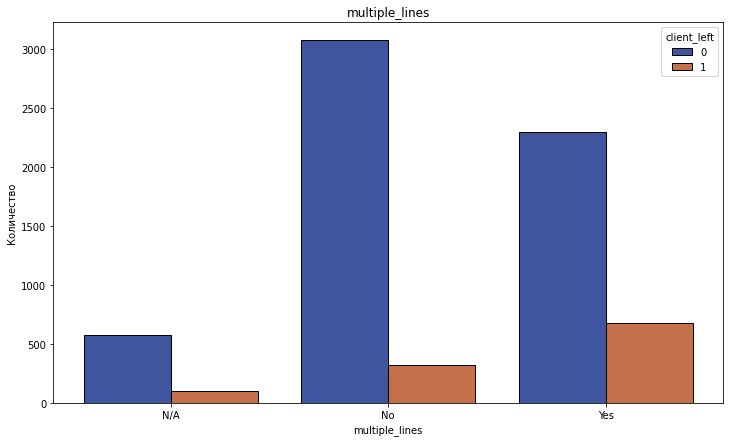

In [ ]:
#Строим диаграммы для категориальных признаков
for i in cat_cols:
    plt.figure(figsize=(12, 7))
    sns.histplot(data=df,
                 x=i,
                 hue='client_left',
                 multiple='dodge',
                 shrink=0.8)
    sns.set_palette('dark')
    plt.ylabel('Количество')
    plt.xlabel(i)
    plt.title(f'{i}')
    plt.show();

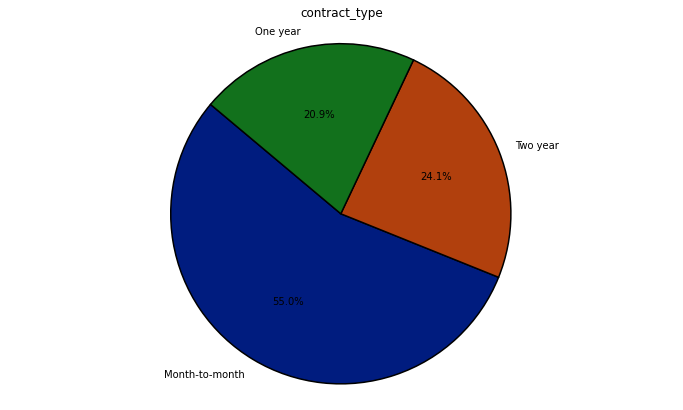

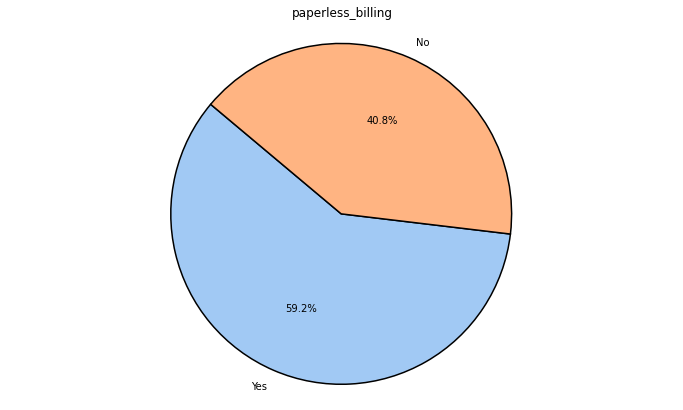

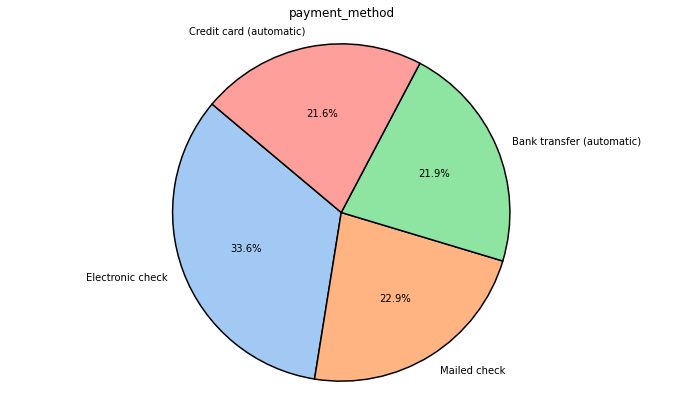

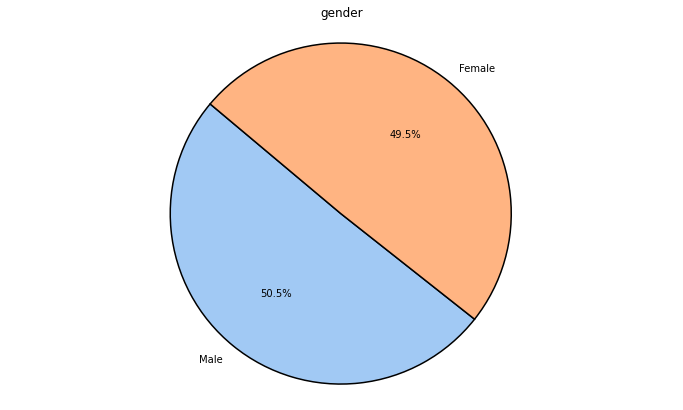

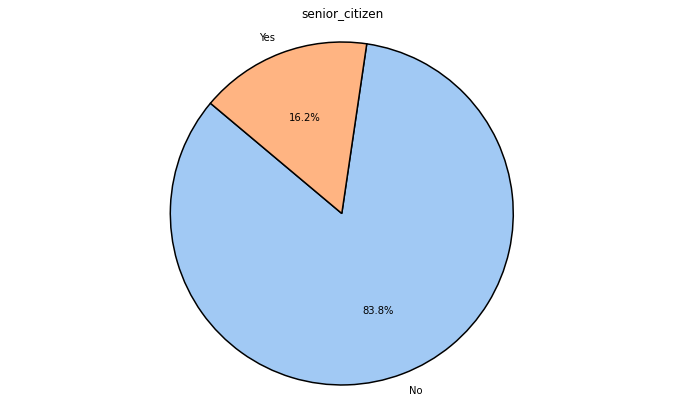

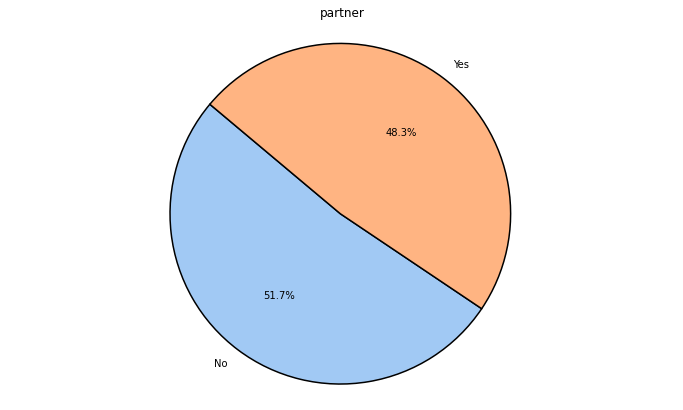

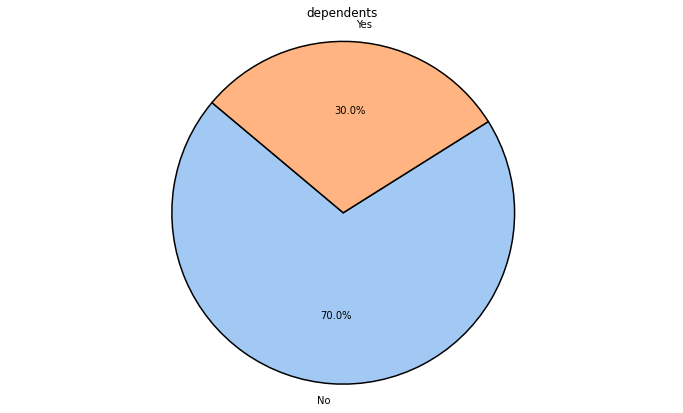

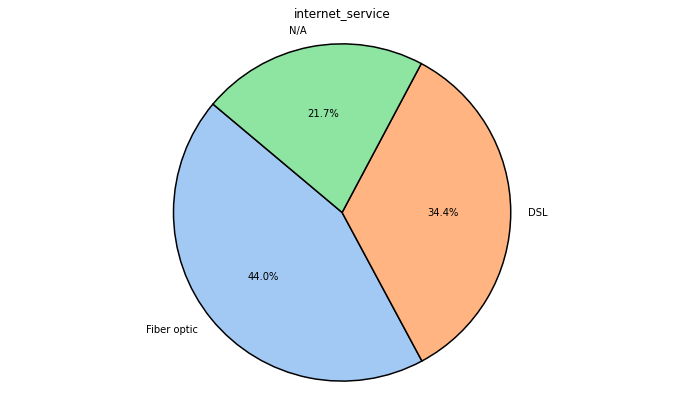

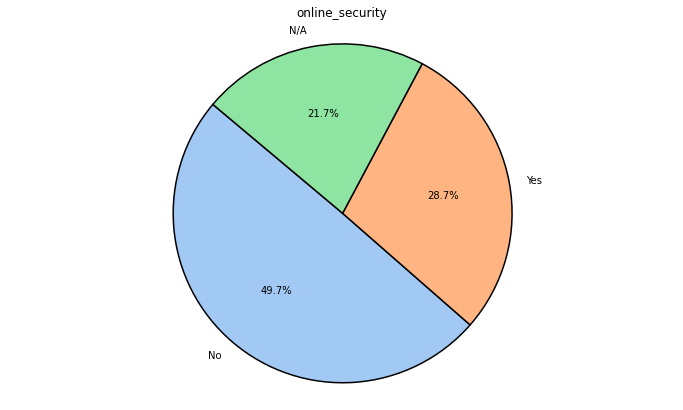

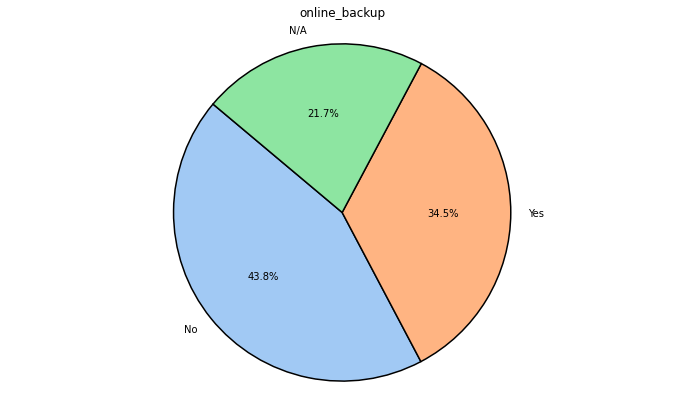

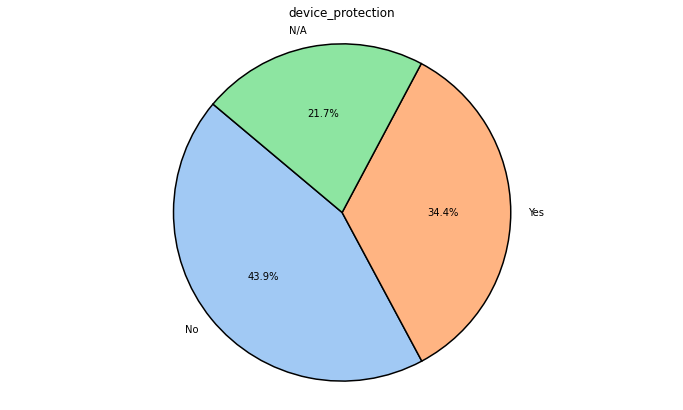

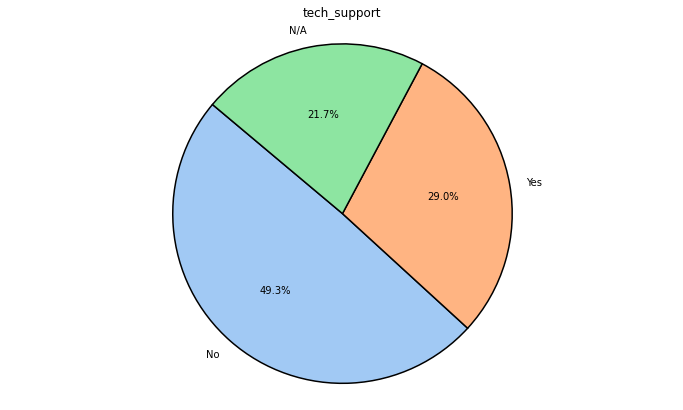

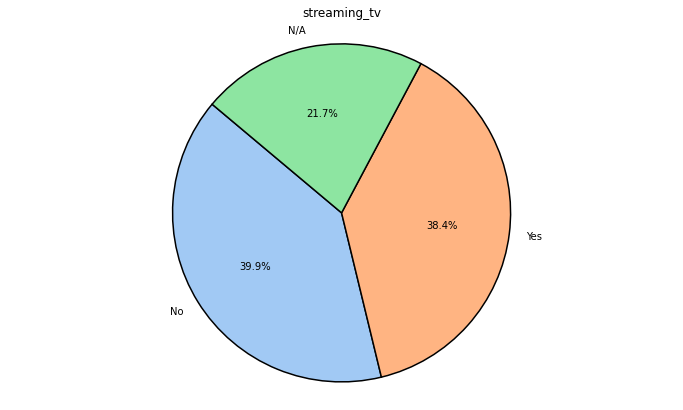

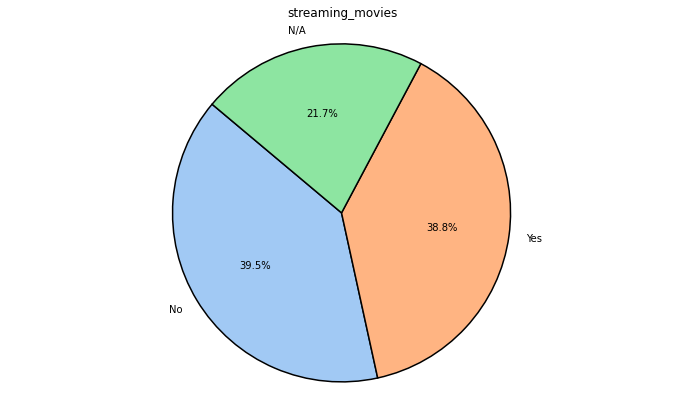

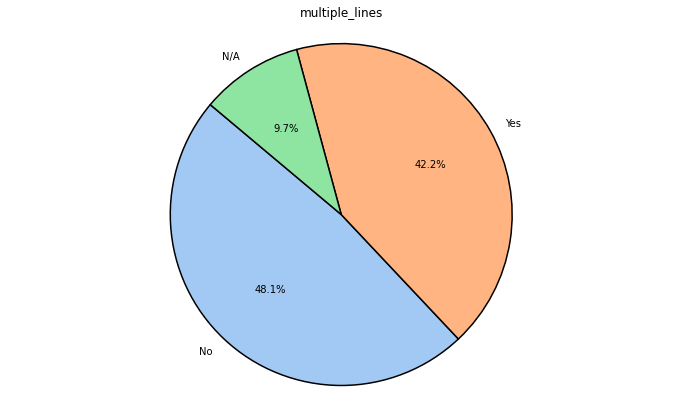

In [ ]:
#Дополнительно построим круговые диаграммы для понимания долей
for i in cat_cols:
    plt.figure(figsize=(12, 7))
    plt.title(f'{i}')
    sns.set_palette('pastel')
    total_counts = df[i].value_counts()
    plt.pie(total_counts, labels=total_counts.index, autopct='%1.1f%%', startangle=140,
                           wedgeprops={'edgecolor': 'black', 'linewidth': 1.5})
    plt.axis('equal')
    plt.show()

Из гистограмм видно следующее:
- При типе контракта month-to-month уходит меньше клиентов, чем при остальных типах
- Соотношение пинсионеров к клиентам помладше 1 к 5
- Реже всего уходят клиенты, оплачивающие услуги почтовым чеком
- Вероятность ухода клиента, состоящего в браке, гораздо выше; холостые клиенты уходят гораздо реже
- Чаще уходят клиенты с возможностью подключения нескольких телефонных линий


Пока не слишком информативно. Посмотрим на графики по количественным столбцам.

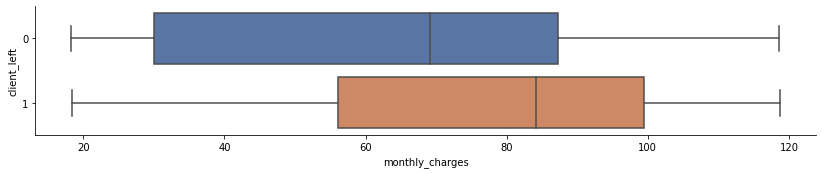

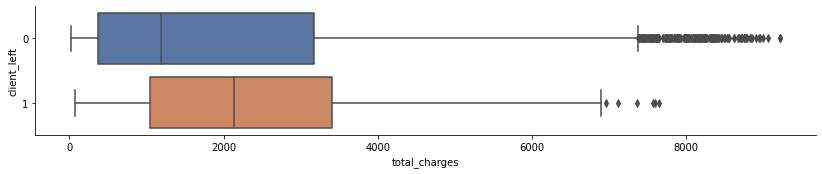

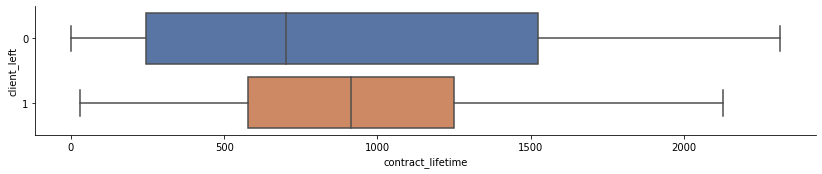

In [ ]:
#Строим диаграммы для категориальных признаков
for i in num_cols:
    sns.set_palette('deep')
    num_plot = sns.catplot(y='client_left', x=i, kind='box', data=df, orient='h')
    num_plot.fig.set_figwidth(12)
    num_plot.fig.set_figheight(2)
    plt.show();

Здесь уже выводы поинтереснее:
- У ушедших клиентов ежемесячные платежи были заметно выше неушедших
- То же самое с общими платежами, медианное значение общих платежей у ушедших в 2 раза выше

Дополнительно проверим баланс классов в целевом признаке.

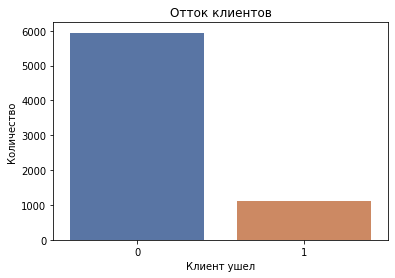

0    84.4
1    15.6
Name: client_left, dtype: float64

In [ ]:
#Построим график оттока клиентов
target_plot = sns.countplot(x='client_left', data=df)
plt.xlabel('Клиент ушел')
plt.ylabel('Количество')
plt.title('Отток клиентов')
plt.show()

percent = round(df['client_left'].value_counts() / len(df) * 100, 1)
display(percent)

Процент ушедших клиентов составляет 15.6% — довольно много. Судя по полученной информации, есть хорошие шансы избежать этого в будущем. Для этого напишем модель предсказания оттока.

### Подведение итогов первого этапа

Мы проделали следующую работу:
- Предобработка данных (объединение, изменение типов данных, заполнение пропущенных значений, создание новых признаков, проверка на дубликаты)
- Определили целевой признак
- Построили матрицу корреляции и оценили влияние других признаков на целевой, а также определили столбцы, от которых стоит избавиться перед обучением моделей
- Построили и изучили диаграммы признаков
- Прокомментировали каждый этап

____________________________________________________________________________________________________________________________

# Вниманию тимлида
1. **Список уточняющих вопросов**
- Вопросов нет, готов приступать к обучению моделей.
2. **Примерный план решения задачи. Пропишите 3–5 основных шагов, каждый поясните не более двумя предложениями.**
- Очистка датасета от лишних столбцов (столбцов, дающих утечку данных, мультиколлинеарность, не имеющих корреляции с целевым признаком)
- Разделение данных на features и target
- Разделение датасета на тренировочную и тестовую выборку в соотношении 3 к 1 с соблюдением баланса классов (для accuracy)
- Масштабирование признаков
- Кодирование признаков
- Обучение 3 моделей: логистической регрессии, случайного леса и градиентного бустинга
- Выбор лучшей модели
- Проверка лучшей модели на тестовой выборке
- Добиться метрики ROC-AUC не ниже 0.85
- Дополнительно получить метрику accuracy для интерпретируемости руководством + матрицу ошибок
3. **Цель проекта**
- Получить рабочую модель предсказания оттока с хорошей метрикой качества
- Описать основные этапы работы и важность признаков
- Предоставить результаты работы других моделей для обоснования выбора
- Дать рекомендации по предобработке и внедрению модели в работу

## Построение моделей

### Подготовка к обучению

Перед разделением данных на выборки, стоит удалить лишние столбцы, о которых мы говорили на этапе предобработки.

In [ ]:
#Удаляем
df = df.drop(['begin_date', 'end_date', 'gender', 'total_charges'], axis=1)

#Проверяем
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   contract_type      7043 non-null   object 
 1   paperless_billing  7043 non-null   object 
 2   payment_method     7043 non-null   object 
 3   monthly_charges    7043 non-null   float64
 4   senior_citizen     7043 non-null   object 
 5   partner            7043 non-null   object 
 6   dependents         7043 non-null   object 
 7   internet_service   7043 non-null   object 
 8   online_security    7043 non-null   object 
 9   online_backup      7043 non-null   object 
 10  device_protection  7043 non-null   object 
 11  tech_support       7043 non-null   object 
 12  streaming_tv       7043 non-null   object 
 13  streaming_movies   7043 non-null   object 
 14  multiple_lines     7043 non-null   object 
 15  client_left        7043 non-null   int64  
 16  contract_lifet

In [ ]:
#Делим данные на features и target
features = df.drop('client_left', axis=1)
target = df['client_left']

#Делим данные на train и test
features_train, features_test, target_train, target_test = train_test_split(
    features,
    target,
    test_size=0.25,
    random_state=RANDOM_STATE,
    stratify=target,
    shuffle=True)

#Проверяем
print(features_train.shape)
print(target_train.shape)
print(features_test.shape)
print(target_test.shape)

(5282, 16)
(5282,)
(1761, 16)
(1761,)


Далее будем масштабировать числовые признаки и кодировать категориальные, а затем обучим модели, но делать все это будем в рамках пайплайна.

### Логистическая регрессия

In [ ]:
#Cоздаем ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['monthly_charges',
                                   'contract_lifetime']),
        ('cat', OneHotEncoder(), ['contract_type',
                                  'paperless_billing',
                                  'payment_method',
                                  'senior_citizen',
                                  'partner',
                                  'dependents',
                                  'internet_service',
                                  'online_security',
                                  'online_backup',
                                  'device_protection',
                                  'tech_support',
                                  'streaming_tv',
                                  'streaming_movies',
                                  'multiple_lines'])
    ])

In [ ]:
#Задаем гиперпараметры для логистической регрессии
lr_param_grid = {'logisticregression__C': [0.01, 0.1, 1, 10],
                 'logisticregression__penalty': ['l2']}

In [ ]:
#Пишем пайплайн
lr_pipe = make_pipeline(
    preprocessor,
    LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced'))

#Задаем гиперпараметры GridSearchCV
lr_grid = GridSearchCV(
    estimator = lr_pipe,
    param_grid = lr_param_grid,
    cv=5,
    scoring ='roc_auc')

In [ ]:
#Обучаем модель
lr_grid.fit(features_train, target_train)

#Получаем лучшую модель
best_lr_model = lr_grid.best_estimator_

In [ ]:
#Выведем результат работы лучшей модели на кросс-валидации
print(f'ROC-AUC на кросс-валидации модели логистической регрессии составляет:{lr_grid.best_score_.round(4)}')

#Выведем гиперпараметры лучшей модели
print(f'Гипетпараметры лучшей модели линейной регрессии:{lr_grid.best_params_}')

ROC-AUC на кросс-валидации модели логистической регрессии составляет:0.7678
Гипетпараметры лучшей модели линейной регрессии:{'logisticregression__C': 10, 'logisticregression__penalty': 'l2'}


Достойный результат для такой простой модели, но задачу в преодоление порога в 0.85 не решает. Переходим к модели случайного леса.

### Случайный лес

In [ ]:
#Cоздаем ColumnTransformer для леса
rf_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['monthly_charges',
                                   'contract_lifetime']),
        ('cat', OrdinalEncoder(), ['contract_type',
                                  'paperless_billing',
                                  'payment_method',
                                  'senior_citizen',
                                  'partner',
                                  'dependents',
                                  'internet_service',
                                  'online_security',
                                  'online_backup',
                                  'device_protection',
                                  'tech_support',
                                  'streaming_tv',
                                  'streaming_movies',
                                  'multiple_lines'])
    ])

In [ ]:
#Задаем гиперпараметры для модели случайного леса
rf_param_grid = {'randomforestclassifier__n_estimators': [50, 100, 200],
                 'randomforestclassifier__max_depth': [1, 10, 20]}

In [ ]:
#Пишем пайплайн
rf_pipe = make_pipeline(
    rf_preprocessor,
    RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced'))

#Задаем гиперпараметры GridSearchCV
rf_grid = GridSearchCV(
    estimator=rf_pipe,
    param_grid=rf_param_grid,
    cv=5,
    scoring='roc_auc')

In [ ]:
#Обучаем модель
rf_grid.fit(features_train, target_train)

#Получаем лучшую модель
best_rf_model = rf_grid.best_estimator_

In [ ]:
#Выведем результат работы лучшей модели на кросс-валидации
print(f'ROC-AUC на кросс-валидации модели случайного леса составляет: {rf_grid.best_score_.round(4)}')

#Выведем гиперпараметры лучшей модели
print(f'Гипетпараметры лучшей модели случайного леса регрессии:{rf_grid.best_params_}')

ROC-AUC на кросс-валидации модели случайного леса составляет: 0.8331
Гипетпараметры лучшей модели случайного леса регрессии:{'randomforestclassifier__max_depth': 10, 'randomforestclassifier__n_estimators': 200}


Модель случайного леса показывает себя лучше логистической регрессии, однако также не дотягивает до порогового значения ROC-AUC в 0.85. Посмотрим, как покажет себя модель градиентного бустинга.

### CatBoost

In [ ]:
#Задаем гиперпараметры для CatBoost
cb_param_grid = {'catboostclassifier__learning_rate': [0.01, 0.4, 0.5],
                 'catboostclassifier__iterations': [100, 500, 600],
                 'catboostclassifier__max_depth': range(2, 5)}

In [ ]:
#Пишем пайплайн
cb_pipe = make_pipeline(
    preprocessor,
    CatBoostClassifier(auto_class_weights='Balanced', random_state=RANDOM_STATE, verbose=False))

#Задаем гиперпараметры GridSearchCV
cb_grid = GridSearchCV(
    estimator=cb_pipe,
    param_grid=cb_param_grid,
    cv=5,
    scoring='roc_auc')

In [ ]:
#Обучаем модель
cb_grid.fit(features_train, target_train)

#Получаем лучшую модель
best_cb_model = cb_grid.best_estimator_

In [ ]:
#Выведем результат работы лучшей модели на кросс-валидации
print(f'ROC-AUC на кросс-валидации модели CatBoost составляет: {cb_grid.best_score_.round(4)}')

#Выведем гиперпараметры лучшей модели
print(f'Гипетпараметры лучшей модели CatBoost регрессии:{cb_grid.best_params_}')

ROC-AUC на кросс-валидации модели CatBoost составляет: 0.9263
Гипетпараметры лучшей модели CatBoost регрессии:{'catboostclassifier__iterations': 500, 'catboostclassifier__learning_rate': 0.4, 'catboostclassifier__max_depth': 2}


Отлично! Catboost показал лучший результат (0.9263) и преодолел целевое значение ROC-AUC в 0.85, а значит, именно эту модель будем проверять на тестовой выборке.

### Проверка лучшей модели на тестовых данных

In [ ]:
#Вычисляем ROC-AUC на тестовых данных
cb_predictions = best_cb_model.predict_proba(features_test)[:, 1]

roc_auc_test = roc_auc_score(target_test, cb_predictions)

print(f'Значение ROC-AUC лучшей модели CatBoost на тестовой выборке составляет: {roc_auc_test.round(4)}')

Значение ROC-AUC лучшей модели CatBoost на тестовой выборке составляет: 0.9287


Мы справились и получили значение ROC-AUC выше 0.85, а именно — 0.9287, что является хорошим результатом.

### Анализ результатов

Построим ROC-кривую для наглядности полученного результата

AUC-ROC: 0.93


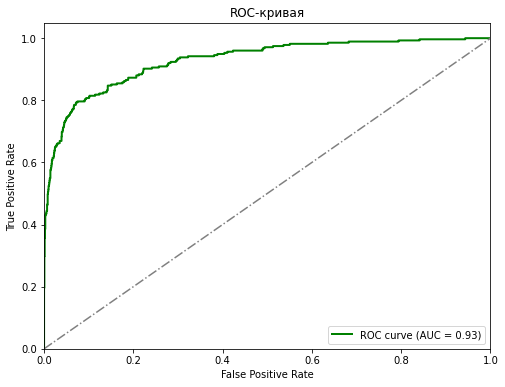

In [ ]:
# Вычисляем ROC-кривую и значение AUC-ROC
fpr, tpr, thresholds = roc_curve(target_test, cb_predictions)

# Выводим значение AUC-ROC
print(f'AUC-ROC: {roc_auc_test:.2f}')

# Строим ROC-кривую
plt.figure(figsize=(8, 6))
plt.plot(fpr,
         tpr,
         color='green',
         lw=2,
         label='ROC curve (AUC = {:.2f})'.format(roc_auc_test))
plt.plot([0, 1],
         [0, 1],
         color='gray',
         linestyle='-.')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc='lower right')
plt.show()

Чем ближе ROC-кривая к верхнему левому углу графика, тем лучше, а наша модель к нему весьма близка.
Это значит, что она обладает высокой чувствительностью и специфичностью для различения классов.
Иными словами, она достаточно хорошо справляется с определением положительных классов из всех истинно положительных примеров и отрицательных классов из всех истинно отрицательных.

Теперь посмотрим на метрику **accuracy** для интерпретации.

In [ ]:
cb_accuracy = accuracy_score(target_test, best_cb_model.predict(features_test))

print(f'Значение accuracy лучшей модели CatBoost на тестовой выборке составляет: {cb_accuracy.round(2)}')

Значение accuracy лучшей модели CatBoost на тестовой выборке составляет: 0.91


Значение **accuracy** на тестовой выборке составляет 0.91, что говорит о высоком качестве модели.  
Фактически, модель правильно предсказывает 91% всех классов в тестовой выборке.

Построим матрицу ошибок.

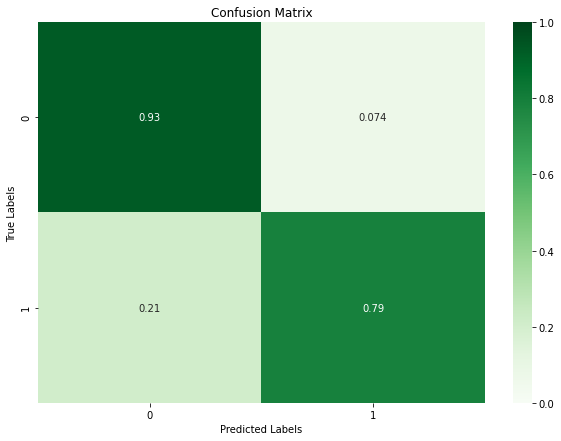

In [ ]:
#Строим матрицу ошибок
predicted_classes = best_cb_model.predict(features_test)

cm = confusion_matrix(target_test, predicted_classes, normalize='true')

plt.figure(figsize=(10, 7))
sns.heatmap(cm,
            annot=True,
            vmin=0,
            vmax=1,
            cmap='Greens')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

- Наша модель хорошо предсказывает отрицательный класс (клиент остался). True Negative = 0.93
- Положительный класс (клиент ушел) предсказывает хуже. True Positive = 0.79

И напоследок посмотрим на важность признаков нашей модели.

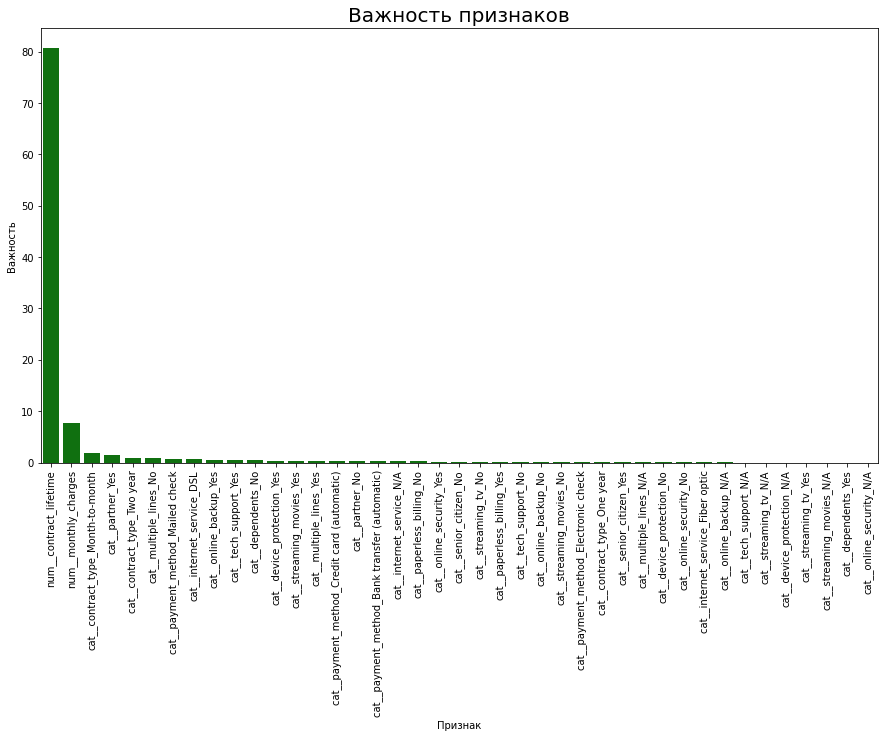

In [ ]:
#Вытаскиваем из трансформера названия признаков
column_transformer = cb_grid.best_estimator_['columntransformer']
transformed_feature_names = column_transformer.get_feature_names_out()

#Создаем датасет для подгрузки в график
importances = pd.DataFrame(data={
    'Признак': transformed_feature_names,
    'Важность': cb_grid.best_estimator_._final_estimator.feature_importances_
})

#Сортируем по важности
importances = importances.sort_values(by='Важность', ascending=False)

#Строим график
plt.figure(figsize=(15, 8))
sns.barplot(x=importances['Признак'], y=importances['Важность'], color='green')
plt.title('Важность признаков', size=20)
plt.xticks(rotation='vertical')
plt.xlabel('Признак')
plt.ylabel('Важность')
plt.show()

Мы наблюдаем два существенно влияющих на модель признака и один чуть менее существенно; остальные признаки почти не влияют на модель и рассматривать их мы не будем.

- Срок действия контракта оказывает максимальное влияние на результат предсказания модели
- Размер ежемесячного платежа тоже существенно влияет, что логично, учитывая рассмотренную нами ранее диаграмму и здравый смысл, говорящий о том, что переплачивать за услуги никто не любит
- Тип контракта month-to-month влияет уже довольно слабо, но это тоже логично, ведь такой тип контракта позволяет ежемесячно пересматривать цену услуг, тогда как остальные варианты предлагают делать это раз в один или два года

### Подведение итогов второго этапа


Мы проделали большую работу:
- Очистили датасет от лишних столбцов
- Разделили данные на тренировочную и тестовую выборки в соотношении 3 к 1 (0.75 на 0.25)
- Написали пайплайн для масштабирования числовых признаков и кодирования категориальных, а также обучили в рамках пайплайна три модели
- Лучшей моделью стала CatBoost со значением ROC-AUC в 0.9287 на тестовой выборке (по условию нужно >= 0.85)
- Построили и проанализировали ROC-кривую
- Для интерпретации модели получили метрику accuracy, у лучшей модели она равна 0.91

- Построили и проанализировали матрицу ошибок
- Построили график важности признаков лучшей модели и разобрали увиденное

Можем переходить к последнему этапу — к отчету!

## Отчет

### План проекта

1. Предобработка и исследовательский анализ данных:
- Загрузка библиотек и датасетов
- Оценка фронта работ на основе общей информации о датасетах
- Объединение датасетов
- Изменение типов данных
- Создание новых признаков (в том числе целевого)
- Заполнение пропущенных значений
- Проверка на дубликаты
- Построение матрицы корреляции
- Построение диаграмм
- Подведение итогов этапа анализа

2. Обучение моделей:
- Очистка датасета от лишних столбцов
- Разделение данных на features и target
- Разделение датасета на тренировочную и тестовую выборку в соотношении 3 к 1
- Построение пайплайнов для масштабирования, кодирования и обучения каждой из трех моделей
- Выбор лучшей модели
- Проверка лучшей модели на тестовой выборке (добиться значения ROC-AUC >= 0.85)
- Анализ результатов
- Подведение итогов этапа обучения моделей

3. Составить отчет по итогам проделанной работы

Проект прошел в соответствии с планом.

### Ключевые шаги в решении задачи

1. Предобработка данных:
- Объединение данных в один единый датафрейм
- Изменение типов данных для корректной работы с признаками
- Создание нового признака, ставшего целевым
- Создание нового признака для последующего обучения модели. Именно этот признак стал ключевым для получения качественной модели с хорошим значением ROC-AUC и accuracy
- Заполнение пропущенных значений (отсутствовали даты оплаты контракта на день выгрузки, а также информация об отсутствии действующих дополнительных услуг у множества клиентов)
- Определение наличия дисбаланса классов для учета в построении моделей (данных об ушедших клиентов значительно меньше, чем об оставшихся)

2. Построение моделей:
- Удаление столбцов, негативно влияющих на обучение модели и её качество
- Обработка данных и обучение разных типов моделей с помощью пайплайна, что позволило избежать утечки данных и повысить качество моделей
- Обучение моделей через подбор гиперпараметров с помощью GridSearchCV, что позволило правильно подобрать их сочетание

Всё перечисленное сыграло ключевую роль в решении задачи и позволило достичь высокого показателя как метрики ROC-AUC, так и accuracy.

### Обучение моделей

1. При построении моделей использовались следующие признаки:

Целевой признак — синтетический столбец `client_left`, полученный на основе данных столбца `end_date`

Количественные:
- `contract_lifetime` — синтетический признак, полученный на основе разницы в датах столбцов `end_date` и `begin_date`
- `monthly_charges`

Категориальные:
- `contract_type`
- `paperless_billing`
- `payment_method`
- `senior_citizen`
- `partner`
- `dependents`
- `internet_service`
- `online_security`
- `online_backup`
- `device_protection`
- `tech_support`
- `streaming_tv`
- `streaming_movies`
- `multiple_lines`

Были удалены:
- `begin_date` и `end_date` — в связи с колоссальным негативным влиянием на качество обучения (утечка данных)
- `gender` — признак, не влияющий на обучение модели, но усложняющий процесс обучения
- `total_charges` — мультиколлинеарность с признаком `contract_lifetime`

Наибольший вклад в обучение лучшей модели внесли:
- `contract_lifetime` — срок действия контракта с клиентом
- `contract_type` — тип контракта (ежемесячный, годовой, двухлетний). Вероятность ухода выше у клиентов с годовым и двухлетним контрактом
- `monthly_charges` — сумма ежемесячного платежа. Чем выше сумма, тем выше шанс, что клиент уйдет

### Результаты обучения моделей

In [ ]:
#Таблица с результатами моделей на валидации
results = [
    {'ROC-AUC': lr_grid.best_score_.round(4)},
    {'ROC-AUC': rf_grid.best_score_.round(4)},
    {'ROC-AUC': cb_grid.best_score_.round(4)}
]

pd.DataFrame(data=results,
             index=['Логистическая регрессия', 'Случайный лес', 'CatBoost'],
             columns=['ROC-AUC'])

,ROC-AUC
Логистическая регрессия,0.7678
Случайный лес,0.8331
CatBoost,0.9263


Как следует из таблицы, лучшие результаты на кросс-валидации с большим отрывом показала модель градиентного бустинга CatBoost Classifier.  

- Сетка гиперпараметров лучшей модели для перебора GridSearchCV выглядит так:
```python
{'catboostclassifier__learning_rate': [0.01, 0.4, 0.5],
 'catboostclassifier__iterations': [100, 500, 600],
 'catboostclassifier__max_depth': range(2, 5)}
```
- Гиперпараметры лучшей модели:
```python
{'catboostclassifier__iterations': 500,
 'catboostclassifier__learning_rate': 0.4,
 'catboostclassifier__max_depth': 2}
```
- Метрики, полученные лучшей моделью на тестовой выборке:

**ROC-AUC 0.9287** при заданной цели в >= 0.85  
**accuracy 0.91**, что говорит о правильном предсказании 91% всех классов в тестовой выборке

### Заключение

Лучший способ существенно улучшить метрику качества модели — добавить больше качественных данных, например, начиная со 2 февраля 2020. Также есть вероятность, что за это время появились дополнительные признаки, которые смогут оказать серьезное влияние на решение задачи оттока клиентов.

Наиболее важным для бизнеса будет подбор корректного порога классификации на основе бюджета на акции по удержанию клиентов.  
Здесь важно правильно оценить стоимость ошибок первого и второго рода.
Суть в том, что ошибка первого рода (ошибочный вывод, что клиент уйдет) на первый взгляд кажется менее критичной, чем ошибка второго рода (ошибочный вывод, что клиент останется), ведь потратить немного денег на удержание клиента, который и так не уйдет лучше, чем полностью лишиться клиента, даже не попытавшись его удержать.  
Однако, потери от ухода одного клиента могут быть менее значительны, чем затраты на предложение акции большому числу клиентов, которые никуда не собирались. Именно поэтому нужно определить порог классификации, в чем аналитикам может помочь матрица ошибок, также разобранная нами в рамках данного проекта.
Из нее следует, что наша модель хорошо предсказывает отрицательный класс (клиент остался) — True Negative = 0.93 и чуть хуже положительный класс (клиент ушел) True Positive = 0.79.